Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Reading in the raw data

In [2]:
airports_csv = pd.read_csv('../data/openFlightsRaw/airports.csv')
routes_csv = pd.read_csv('../data/openFlightsRaw/routes.csv')

Verifying that columns I want to use for joining to not have any nulls
Additionally verifying that there are no duplicated routes in routes_csv

In [3]:
print(routes_csv['SRC_AIRPT_ID'].isnull().values.any())
print(routes_csv['DESTIN_AIRPT_ID'].isnull().values.any())
print(airports_csv['AIRPT_ID'].isnull().values.any())

print(routes_csv.duplicated().any())

False
False
False
False


Verifying the data types of the columns I want to join on

In [4]:
print(type(routes_csv['SRC_AIRPT_ID'][0]))
print(type(routes_csv['DESTIN_AIRPT_ID'][0]))
print(type(airports_csv['AIRPT_ID'][0]))

<class 'str'>
<class 'str'>
<class 'numpy.int64'>


The AIRPT_ID is a int in the airport_csv, so I will need to change types to join data

In [5]:
airports_csv['AIRPT_ID'] = (airports_csv['AIRPT_ID']).astype(str)

'\N' is used instead if a null for this datset

In [6]:
nullVal = r"\N"
routes_csv = routes_csv[routes_csv['SRC_AIRPT_ID'] != nullVal]
routes_csv = routes_csv[routes_csv['DESTIN_AIRPT_ID'] != nullVal]

Tracking the size of routes, once joining has finished it should be the same

In [7]:
len(routes_csv.index)

67240

I had assumed that the ids were in numerical order, and didn't have any holes, but that assumption was wrong, what this means there are airports in the routes data, that are not in the airports data.

In the chart below, you can see how the IDs for the last 1000 elements in our dataset jump from 10,000 to 14,000.

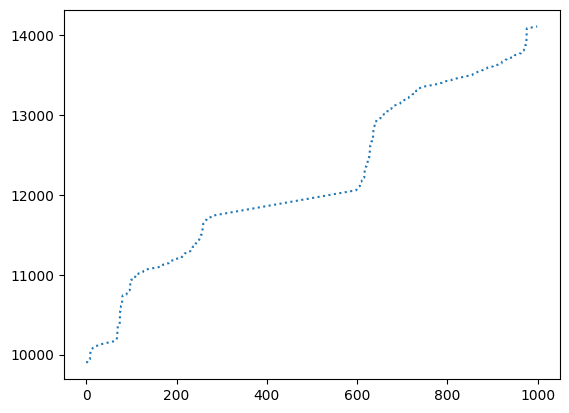

In [8]:
airports_csv_Example = pd.read_csv('../data/openFlightsRaw/airports.csv')
airports_csv_Example = airports_csv_Example.tail(1000)
airportIdPoints = np.array(airports_csv_Example['AIRPT_ID'])

plt.plot(airportIdPoints, linestyle='dotted')

Joining source and destination airports onto the routes.
Using inner joins gets rid of the airports that aren't in the airports.csv
This provides a name that the Google API can use, so distance can be obtained

In [9]:
routeDistSrc = routes_csv.merge(airports_csv, how='inner', left_on='SRC_AIRPT_ID', right_on='AIRPT_ID')

routeDistSrc['SRCNAME'] = routeDistSrc['NAME']
routeDistSrc['SRCCTY'] = routeDistSrc['CTY']
routeDistSrc['SRCCTRY'] = routeDistSrc['CTRY']
srcCols = ['AIRLINE', 'AIRLINE_ID', 'SRC_AIRPT', 'SRC_AIRPT_ID', 'SRCNAME', 'SRCCTY', 'SRCCTRY', 'DESTN_AIRPT', 'DESTIN_AIRPT_ID', 'CDSHARE', 'STOPS', 'EQPT']
routeDistSrc = routeDistSrc[srcCols]

routeDistDestin = routes_csv.merge(airports_csv, how='inner', left_on='DESTIN_AIRPT_ID', right_on='AIRPT_ID')

routeDistDestin['DESTINNAME'] = routeDistDestin['NAME']
routeDistDestin['DESTINCTY'] = routeDistDestin['CTY']
routeDistDestin['DESTINCTRY'] = routeDistDestin['CTRY']
destinCols = ['AIRLINE', 'AIRLINE_ID', 'SRC_AIRPT', 'SRC_AIRPT_ID', 'DESTN_AIRPT', 'DESTIN_AIRPT_ID', 'DESTINNAME', 'DESTINCTY', 'DESTINCTRY', 'CDSHARE', 'STOPS', 'EQPT']
routeDistDestin = routeDistDestin[destinCols]

routeMergeCols = ['AIRLINE', 'AIRLINE_ID', 'SRC_AIRPT', 'SRC_AIRPT_ID', 'DESTN_AIRPT', 'DESTIN_AIRPT_ID', 'CDSHARE', 'STOPS', 'EQPT']
routeDist = routeDistSrc.merge(routeDistDestin, how='inner', on=routeMergeCols)

Verified there are less rows now, due to inner join

In [10]:
len(routeDist.index)

66771

My original intent for the EDA was to figure out which countries have the highest distance, Google's API has been difficult for gathering the data efficiently.
The effort is currently stored under dataEngineering/distance.py

In [11]:
routeDist.to_csv('../data/routesDist.csv')

The next path for me to take, is to see which airports have the most traffic, this will help me use the distance calculation for common routes with future work

In [12]:
routeDist['countVal'] = 1
srcAIRPTS = routeDist.groupby('SRCNAME')['countVal'].sum()
destinAIRPTS = routeDist.groupby('DESTINNAME')['countVal'].sum()

airportCnt = airports_csv.merge(srcAIRPTS, how='inner', left_on='NAME', right_on='SRCNAME')
airportCnt = airportCnt.rename(columns={'countVal': 'SRCCNT'})
airportCnt = airportCnt.merge(destinAIRPTS, how='inner', left_on='NAME', right_on='DESTINNAME')
airportCnt = airportCnt.rename(columns={'countVal': 'DESTINCNT'})

There appears to be a linear relation in how often the airport is used as a source and a destination within the dataset.

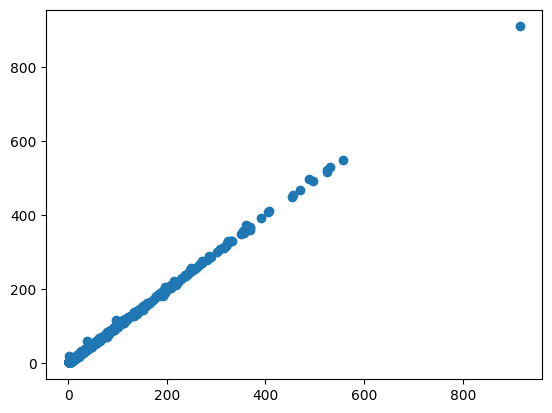

In [40]:
plt.scatter(airportCnt['SRCCNT'], airportCnt['DESTINCNT']);

The most popular airport is Hartsfield Jackson Atlanta International Airport

In [14]:
airportCnt[airportCnt['SRCCNT'] > 800]

,AIRPT_ID,NAME,CTY,CTRY,IATA,ICAO,LAT,LONG,ALT,TZ,DST,DBTZ,TYPE,SRC,SRCCNT,DESTINCNT
1806,3682,Hartsfield Jackson Atlanta International Airport,Atlanta,United States,ATL,KATL,33.6367,-84.428101,1026,-5,A,America/New_York,airport,OurAirports,915,911


We can use the data above to figure out which countries have the most route data. 
It looks like China and the United States have the most route data 

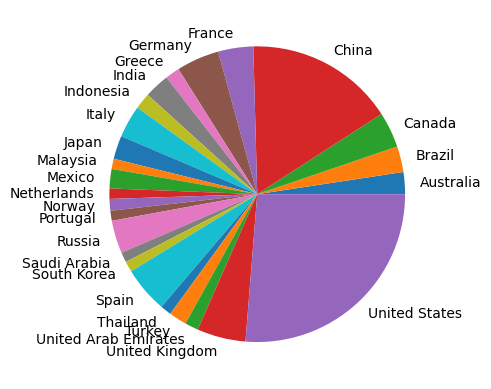

In [39]:
srcCtryCnt = airportCnt.groupby('CTRY')['SRCCNT'].sum()

srcCtryCntPi = srcCtryCnt[srcCtryCnt > 500]
labs = srcCtryCntPi.index
plt.pie(srcCtryCntPi, labels = labs);

Removing some of the outlier values and looking at the top highest countries with source routes, to verify source and destination linear trend

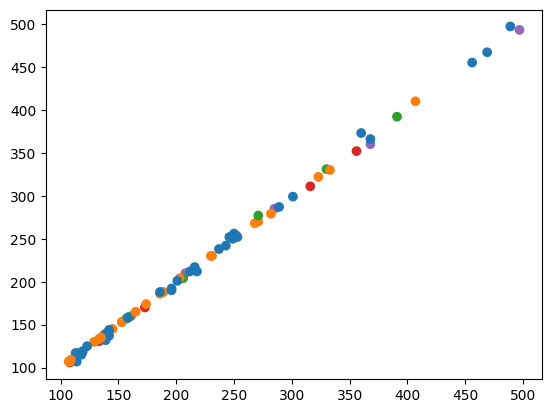

In [46]:
ctrys = ['United States', 'China', 'Spain', 'United Kingdom', 'Germany']
colors = {'United States':'tab:blue', 'China':'tab:orange', 'Spain':'tab:green', 'United Kingdom':'tab:red', 'Germany':'tab:purple'}

airportCntFiltered = airportCnt[airportCnt['CTRY'].isin(ctrys)]
airportCntFiltered = airportCntFiltered[airportCntFiltered['SRCCNT'] < 500]
airportCntFiltered = airportCntFiltered[airportCntFiltered['SRCCNT'] > 100]
plt.scatter(airportCntFiltered['SRCCNT'], airportCntFiltered['DESTINCNT'], c=airportCntFiltered['CTRY'].map(colors));

Based on these results, to add more data to the openFlights dataset, we can focus on a sub-set of about 10 or so countries. Get distance for those routes.

My current recommendation is to start small with the United States dataset.